In [1]:
"""HW 4 Submission - Scott Thomas Andersen - ATMS 523."""

'HW 4 Submission - Scott Thomas Andersen - ATMS 523.'

In [2]:
# Imports
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The data and land sea mask is available here: [https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)

In [3]:
# Data is stored in dataset.grib
ds = xr.load_dataset("dataset2.grib", engine="cfgrib")
ds

<xarray.Dataset> Size: 3GB
Dimensions:     (time: 561, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B 0
  * time        (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2025-09-01
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    valid_time  (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2025-09-01
Data variables:
    sst         (time, latitude, longitude) float32 843MB nan nan ... nan nan
    lsm         (time, latitude, longitude) float32 843MB 0.9839 ... 0.9546
    tcwv        (time, latitude, longitude) float32 843MB 1.102 1.112 ... 5.668
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-24T22:32 GRIB to CDM+CF via cfgrib-0.9.1...

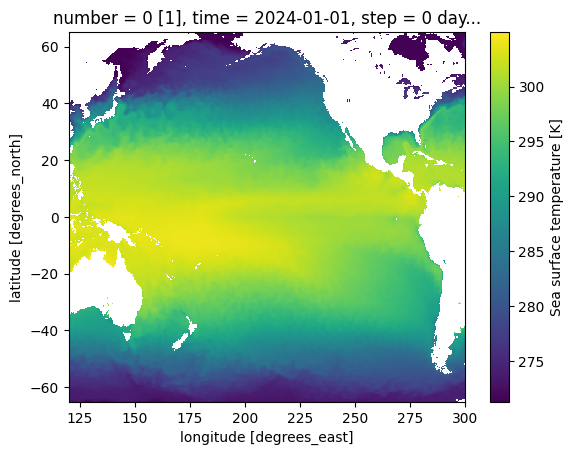

In [4]:
ds.sst.sel(time="2024-01-01").plot()

2)  From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data. Then, standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)



In [5]:
# Provided code snippet
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (
        time - time.isel({time_dim: 0})
    ).astype("timedelta64[s]").astype("int64").astype("float64")


def linear_detrend(obj: xr.DataArray | xr.Dataset,
                   time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.

    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)

    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                # (time, ...)
        t_b = t.broadcast_like(da)         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) \
        else _detrend_da(obj)


def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    Remove monthly climatology and compute monthly z-scores.

    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else \
        detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

In [6]:
detr = linear_detrend(ds[["sst", "tcwv"]])
anom, z = monthly_anom_and_z(detr)
mask = ds.lsm
z

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 561, latitude: 521, longitude: 721)
Coordinates:
    number      (time) int64 4kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * time        (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2025-09-01
    step        (time) timedelta64[ns] 4kB 00:00:00 00:00:00 ... 00:00:00
    surface     (time) float64 4kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    valid_time  (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2025-09-01
    month       (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 ... 12 1 2 3 4 5 6 7 8 9
Data variables:
    sst         (time, latitude, longitude) float32 843MB nan nan ... nan nan
    tcwv        (time, latitude, longitude) float32 843MB -0.8243 ... 1.553

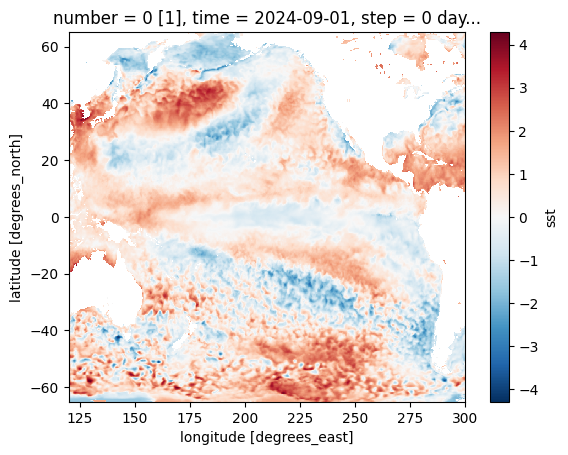

In [7]:
z.sst.sel(time="2024-09-01").plot()

3) Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.


In [8]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(z.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(z.sst, weights=wgts)

In [9]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof = solver.eofsAsCorrelation(neofs=5)
pc = solver.pcs(npcs=5, pcscaling=1)

In [10]:
eof

<xarray.DataArray 'eofs' (mode: 5, latitude: 521, longitude: 721)> Size: 15MB
array([[[        nan,         nan,         nan, ...,  0.06206967,
          0.06900984,  0.07419924],
        [        nan,         nan,         nan, ...,  0.0716144 ,
          0.08016639,  0.08740915],
        [        nan,         nan,         nan, ...,  0.0818639 ,
          0.09215951,  0.09964624],
        ...,
        [-0.09191262, -0.08661291, -0.08042232, ...,         nan,
                 nan,         nan],
        [-0.09139092, -0.0901137 , -0.08819259, ...,         nan,
                 nan,         nan],
        [-0.05273445, -0.05214852, -0.05010953, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.03809501,
          0.04846463,  0.0572343 ],
        [        nan,         nan,         nan, ...,  0.0479855 ,
          0.05937567,  0.06813067],
        [        nan,         nan,         nan, ...,  0.04792846,
          0.05660824,  0.06261826],
...
        [-0.06532935, -0.07013398, -0.07414675, ...,         nan,
                 nan,         nan],
        [-0.05983028, -0.06305558, -0.06564977, ...,         nan,
                 nan,         nan],
        [-0.05010879, -0.05020663, -0.04750123, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.14391197,
          0.15654708,  0.16719491],
        [        nan,         nan,         nan, ...,  0.14322686,
          0.1522059 ,  0.15887445],
        [        nan,         nan,         nan, ...,  0.14218479,
          0.15035591,  0.15620062],
        ...,
        [-0.09593716, -0.09321565, -0.0902911 , ...,         nan,
                 nan,         nan],
        [-0.09268468, -0.09335477, -0.09400597, ...,         nan,
                 nan,         nan],
        [-0.0965763 , -0.09657785, -0.09505817, ...,         nan,
                 nan,         nan]]], shape=(5, 521, 721))
Coordinates:
  * mode       (mode) int64 40B 0 1 2 3 4
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
Attributes:
    long_name:  correlation_between_pcs_and_sst

In [11]:
pc

<xarray.DataArray 'pcs' (time: 561, mode: 5)> Size: 11kB
array([[-0.19023101,  0.7693081 , -0.7627467 ,  1.5083486 , -0.11206092],
       [ 0.12613778,  0.4191406 , -0.47679633,  2.6835806 ,  0.45259014],
       [ 0.5038186 ,  0.68669486, -0.30073458,  1.4113584 ,  1.0659685 ],
       ...,
       [ 0.21866597, -0.26669335, -0.7149054 ,  1.4657578 ,  0.37935486],
       [-0.01836259,  0.01732366, -1.2897757 ,  0.823773  ,  0.17332862],
       [ 0.04175355, -0.17625724, -1.4249467 ,  0.17304276,  0.16331565]],
      shape=(561, 5), dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2025-09-01
  * mode        (mode) int64 40B 0 1 2 3 4
    number      (time) int64 4kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    step        (time) timedelta64[ns] 4kB 00:00:00 00:00:00 ... 00:00:00
    surface     (time) float64 4kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    valid_time  (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2025-09-01
    month       (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 ... 12 1 2 3 4 5 6 7 8 9

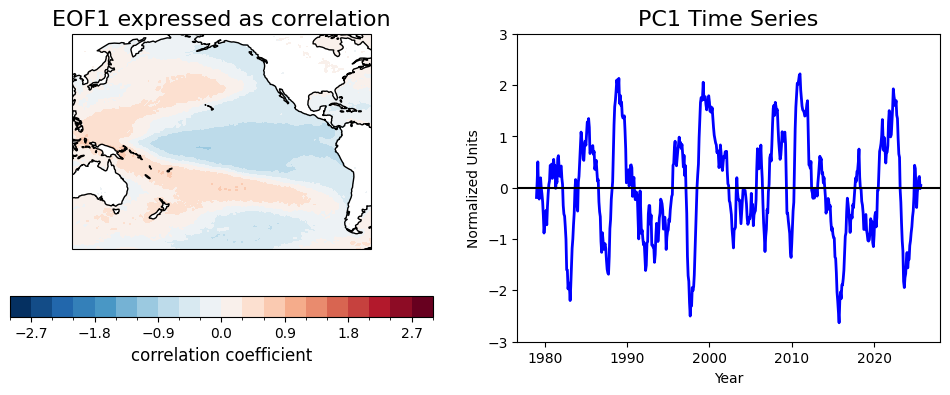

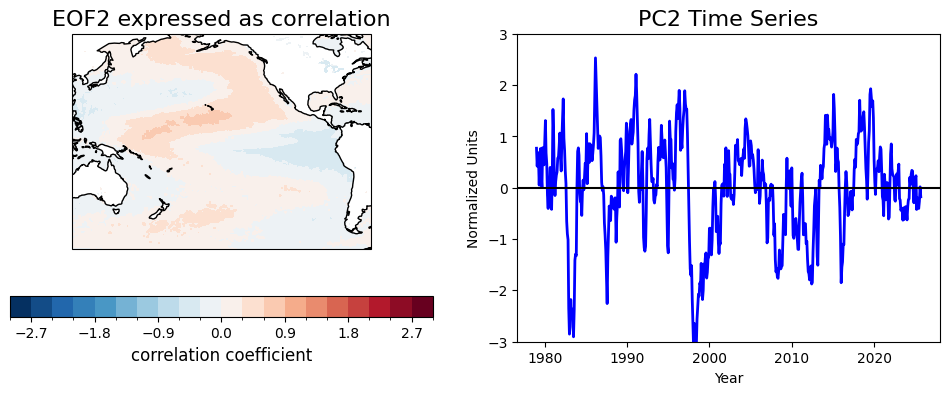

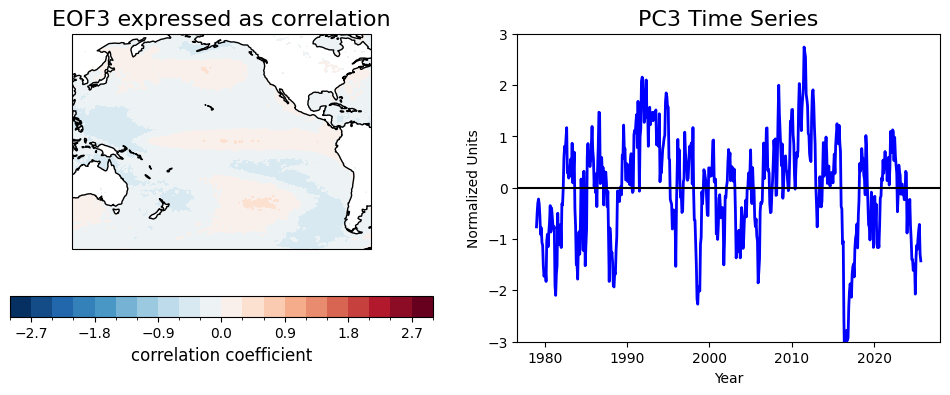

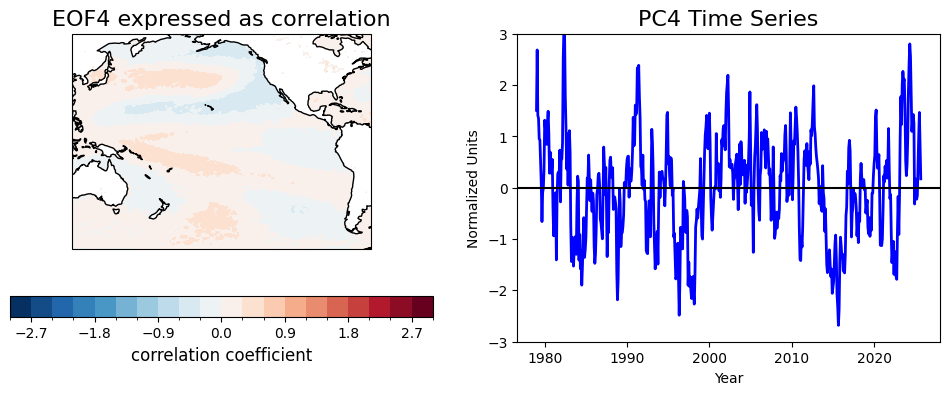

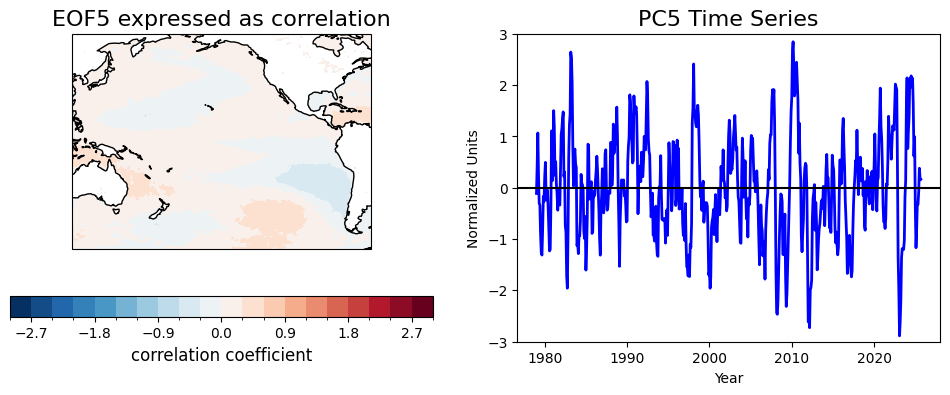

In [12]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
def plot_eof(i, eof, pc):
    """Plot the eof to visualize where the variance for this component."""
    clevs = np.linspace(-3, 3, 21)
    fig, axes = plt.subplots(1, 2,
                             figsize=(12, 4),
                             subplot_kw={
                                 'projection':
                                     ccrs.PlateCarree(central_longitude=190)
                             }
                             )

    ax = axes[0]
    fill = eof[i].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                                add_colorbar=False,
                                transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    cb = plt.colorbar(fill, orientation='horizontal')
    cb.set_label('correlation coefficient', fontsize=12)
    ax.set_title(f'EOF{i+1} expressed as correlation', fontsize=16)

    # Plot the second PC time series.
    axes[1].remove()  # Remove the map projection
    ax2 = fig.add_subplot(1, 2, 2)
    pc[:, i].plot(color='b', linewidth=2)
    ax2.axhline(0, color='k')
    ax2.set_ylim(-3, 3)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Normalized Units')
    ax2.set_title(f'PC{i+1} Time Series', fontsize=16)


plot_eof(0, eof, pc)
plot_eof(1, eof, pc)
plot_eof(2, eof, pc)
plot_eof(3, eof, pc)
plot_eof(4, eof, pc)


4) Plot the percent of variance explained by the first 10 EOFs.

(5.411919488398052e-14, 18.900299072265625)

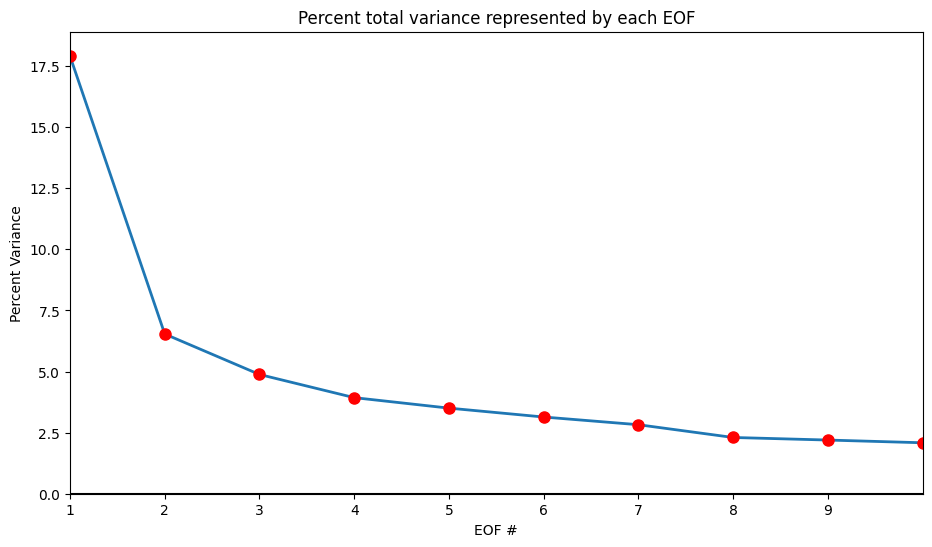

In [13]:
varfrac = solver.varianceFraction()

# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11, 6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10]*100, linewidth=2)
plt.plot(eof_num, varfrac[0:10]*100, linestyle='None',
         marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 10))
plt.title('Percent total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Percent Variance')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac)*100, (np.max(varfrac)+0.01)*100)

5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series (which will be "retrended" and "unstandardized") and the "observed" SST time series.

In [14]:
reconstruction = solver.reconstructedField(5)

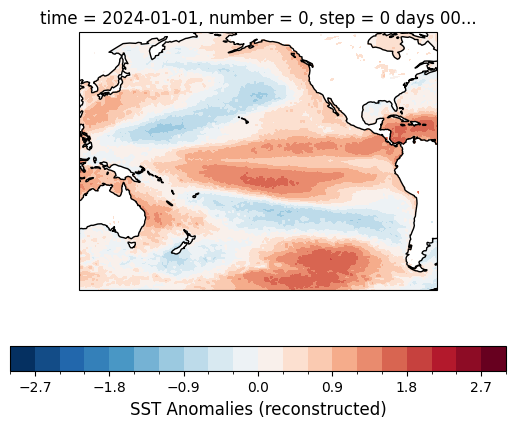

In [15]:
clevs = np.linspace(-3, 3, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
r = reconstruction.sel(time='2024-01-01', method='nearest')
fill = r.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                   add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('SST Anomalies (reconstructed)', fontsize=12)

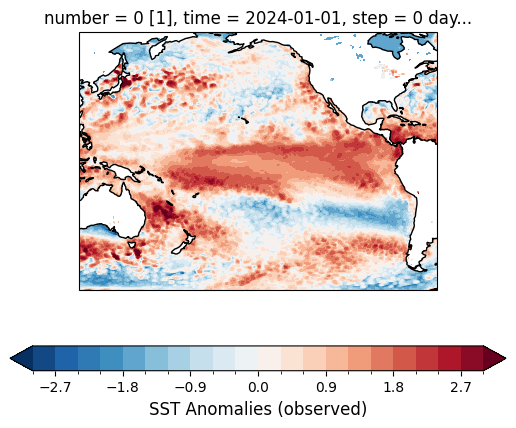

In [16]:
clevs = np.linspace(-3, 3, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
zs = z.sst.sel(time='2024-01-01', method='nearest')
fill = zs.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                   add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('SST Anomalies (observed)', fontsize=12)

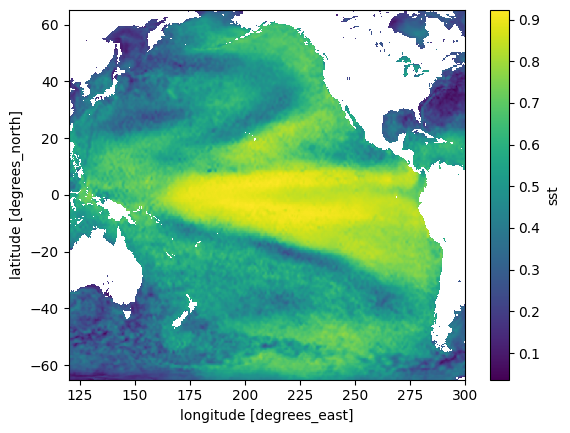

In [17]:
xr.corr(z.sst, reconstruction, dim="time").plot()

6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot).  See anything interesting?

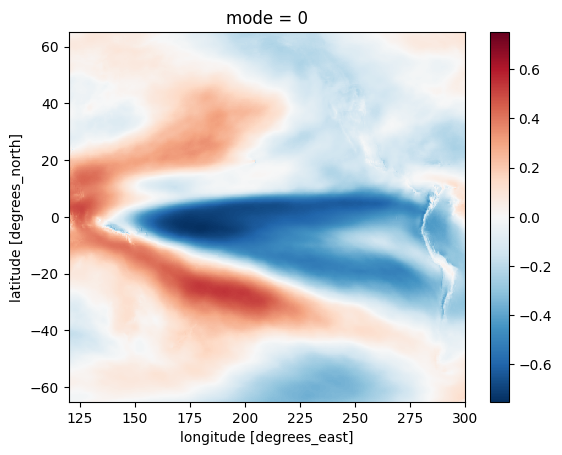

In [18]:
# Get the total column water vapor over the sea.
xr.corr(pc[:, 0], z.tcwv, dim="time").plot()

I notice that there is a high magnitude correlation for the PC of EOF1 over the ENSO region of the pacific. Because the correlation is negative in EOF1 I believe this tells us that there is a very high correlation with total column water vapor when the SST is warm. This seems intuitive but the fact that this correlation is especially strong over the ENSO is interesting and tells us that the first principal component highly captures the impact of el niño events with TCWV.